<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B9%81%E0%B8%9B%E0%B8%81%E0%B9%86%E0%B8%A3%E0%B8%AD%E0%B8%9A%E0%B8%97%E0%B8%B5%E0%B9%882_Train_Female125_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [5]:
import pandas as pd
import shutil

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/Data_Female_125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
1,2,1,7,Y07F,Flip_V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
2,3,2,7,Y07F,V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
3,4,2,7,Y07F,Flip_V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
4,5,3,7,Y07F,V3.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
...,...,...,...,...,...,...,...,...
2370,121,65,25,Y25F,Flip_J145.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2371,122,66,25,Y25F,Flip_J149.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2372,123,67,25,Y25F,Flip_J158.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2373,124,68,25,Y25F,Flip_J177.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt


##ขาดอายุ 14

In [8]:
classes = ['Y07F','Y08F','Y09FF','Y10F','Y11F','Y12F','Y13F','15F','14F','Y16F','Y17F','Y18F','Y19F','Y20F','Y21F','Y22F','Y23F','Y24F','Y25F']
len(classes)

19

In [9]:
df.shape

(2375, 8)

In [10]:
print(set(df['Class']))
print(set(df['Sex']))
print(set(df['Floder']))

{'Y10F', 'Y08F', 'Y16F', 'Y25F', 'Y13F', 'Y21F', 'Y19F', 'Y09F', 'Y22F', 'Y07F', 'Y14F', 'Y17F', 'Y11F', 'Y24F', 'Y12F', 'Y18F', 'Y20F', 'Y15F', 'Y23F'}
{'เพศหญิง'}
{'Lt', 'Rt', 'Both'}


#Imports

In [11]:
import pandas as pd
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
     

#กำหนดค่าพารามิเตอร์


In [12]:
batch_size = 16
width = 150
height = 150
epochs = 2
NUM_TRAIN = 1425
NUM_TEST = 475
dropout_rate = 0.2
input_shape = (height, width, 3) #คือการปิดบาง Node หรือเรียกว่าทำการ Drop Out ไป ซึ่งขึ้นกับการตั้งค่าว่าจะให้ลืมไปกี่เปอร์เซนต์ดี ช่วยในการแก้ปัญหา Overfitting

#Clone efficientnet repo


In [13]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 464 (delta 205), reused 157 (delta 130), pack-reused 184
Receiving objects: 100% (464/464), 8.81 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (278/278), done.
/content/efficientnet_keras_transfer_learning


In [14]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [15]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 1s 0us/step


In [16]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

#Data

##สร้างโฟลเดอร์ Train Valodation และ Test

In [17]:
base_dir = '/content/drive/MyDrive/TVT_Female125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

##สร้างโฟลเดอร์ Train ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [18]:
# train_Y07F_dir = os.path.join(train_dir, 'Y07F')
# os.makedirs(train_Y07F_dir, exist_ok=True)

# train_Y08F_dir = os.path.join(train_dir, 'Y08F')
# os.makedirs(train_Y08F_dir, exist_ok=True)

# train_Y09F_dir = os.path.join(train_dir, 'Y09F')
# os.makedirs(train_Y09F_dir, exist_ok=True)

# train_Y10F_dir = os.path.join(train_dir, 'Y10F')
# os.makedirs(train_Y10F_dir, exist_ok=True)

# train_Y11F_dir = os.path.join(train_dir, 'Y11F')
# os.makedirs(train_Y11F_dir, exist_ok=True)

# train_Y12F_dir = os.path.join(train_dir, 'Y12F')
# os.makedirs(train_Y12F_dir, exist_ok=True)

# train_Y13F_dir = os.path.join(train_dir, 'Y13F')
# os.makedirs(train_Y13F_dir, exist_ok=True)

# train_Y14F_dir = os.path.join(train_dir, 'Y14F')
# os.makedirs(train_Y14F_dir, exist_ok=True)

# train_Y15F_dir = os.path.join(train_dir, 'Y15F')
# os.makedirs(train_Y15F_dir, exist_ok=True)

# train_Y16F_dir = os.path.join(train_dir, 'Y16F')
# os.makedirs(train_Y16F_dir, exist_ok=True)

# train_Y17F_dir = os.path.join(train_dir, 'Y17F')
# os.makedirs(train_Y17F_dir, exist_ok=True)

# train_Y18F_dir = os.path.join(train_dir, 'Y18F')
# os.makedirs(train_Y18F_dir, exist_ok=True)

# train_Y19F_dir = os.path.join(train_dir, 'Y19F')
# os.makedirs(train_Y19F_dir, exist_ok=True)

# train_Y20F_dir = os.path.join(train_dir, 'Y20F')
# os.makedirs(train_Y20F_dir, exist_ok=True)

# train_Y21F_dir = os.path.join(train_dir, 'Y21F')
# os.makedirs(train_Y21F_dir, exist_ok=True)

# train_Y22F_dir = os.path.join(train_dir, 'Y22F')
# os.makedirs(train_Y22F_dir, exist_ok=True)

# train_Y23F_dir = os.path.join(train_dir, 'Y23F')
# os.makedirs(train_Y23F_dir, exist_ok=True)

# train_Y24F_dir = os.path.join(train_dir, 'Y24F')
# os.makedirs(train_Y24F_dir, exist_ok=True)

# train_Y25F_dir = os.path.join(train_dir, 'Y25F')
# os.makedirs(train_Y25F_dir, exist_ok=True)

##สร้างโฟลเดอร์ Validation ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [19]:
# validation_Y07F_dir = os.path.join(validation_dir, 'Y07F')
# os.makedirs(validation_Y07F_dir, exist_ok=True)


# validation_Y08F_dir = os.path.join(validation_dir, 'Y08F')
# os.makedirs(validation_Y08F_dir, exist_ok=True)


# validation_Y09F_dir = os.path.join(validation_dir, 'Y09F')
# os.makedirs(validation_Y09F_dir, exist_ok=True)


# validation_Y10F_dir = os.path.join(validation_dir, 'Y10F')
# os.makedirs(validation_Y10F_dir, exist_ok=True)

# validation_Y11F_dir = os.path.join(validation_dir, 'Y11F')
# os.makedirs(validation_Y11F_dir, exist_ok=True)

# validation_Y12F_dir = os.path.join(validation_dir, 'Y12F')
# os.makedirs(validation_Y12F_dir, exist_ok=True)

# validation_Y13F_dir = os.path.join(validation_dir, 'Y13F')
# os.makedirs(validation_Y13F_dir, exist_ok=True)

# validation_Y14F_dir = os.path.join(validation_dir, 'Y14F')
# os.makedirs(validation_Y14F_dir, exist_ok=True)

# validation_Y15F_dir = os.path.join(validation_dir, 'Y15F')
# os.makedirs(validation_Y15F_dir, exist_ok=True)

# validation_Y16F_dir = os.path.join(validation_dir, 'Y16F')
# os.makedirs(validation_Y16F_dir, exist_ok=True)

# validation_Y17F_dir = os.path.join(validation_dir, 'Y17F')
# os.makedirs(validation_Y17F_dir, exist_ok=True)

# validation_Y18F_dir = os.path.join(validation_dir, 'Y18F')
# os.makedirs(validation_Y18F_dir, exist_ok=True)

# validation_Y19F_dir = os.path.join(validation_dir, 'Y19F')
# os.makedirs(validation_Y19F_dir, exist_ok=True)

# validation_Y20F_dir = os.path.join(validation_dir, 'Y20F')
# os.makedirs(validation_Y20F_dir, exist_ok=True)

# validation_Y21F_dir = os.path.join(validation_dir, 'Y21F')
# os.makedirs(validation_Y21F_dir, exist_ok=True)

# validation_Y22F_dir = os.path.join(validation_dir, 'Y22F')
# os.makedirs(validation_Y22F_dir, exist_ok=True)

# validation_Y23F_dir = os.path.join(validation_dir, 'Y23F')
# os.makedirs(validation_Y23F_dir, exist_ok=True)

# validation_Y24F_dir = os.path.join(validation_dir, 'Y24F')
# os.makedirs(validation_Y24F_dir, exist_ok=True)

# validation_Y25F_dir = os.path.join(validation_dir, 'Y25F')
# os.makedirs(validation_Y25F_dir, exist_ok=True)

##สร้างโฟลเดอร์ Test ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [20]:
# test_Y07F_dir = os.path.join(test_dir, 'Y07F')
# os.makedirs(test_Y07F_dir, exist_ok=True)

# test_Y08F_dir = os.path.join(test_dir, 'Y08F')
# os.makedirs(test_Y08F_dir, exist_ok=True)


# test_Y09F_dir = os.path.join(test_dir, 'Y09F')
# os.makedirs(test_Y09F_dir, exist_ok=True)

# test_Y10F_dir = os.path.join(test_dir, 'Y10F')
# os.makedirs(test_Y10F_dir, exist_ok=True)

# test_Y11F_dir = os.path.join(test_dir, 'Y11F')
# os.makedirs(test_Y11F_dir, exist_ok=True)


# test_Y12F_dir = os.path.join(test_dir, 'Y12F')
# os.makedirs(test_Y12F_dir, exist_ok=True)


# test_Y13F_dir = os.path.join(test_dir, 'Y13F')
# os.makedirs(test_Y13F_dir, exist_ok=True)


# test_Y14F_dir = os.path.join(test_dir, 'Y14F')
# os.makedirs(test_Y14F_dir, exist_ok=True)


# test_Y15F_dir = os.path.join(test_dir, 'Y15F')
# os.makedirs(test_Y15F_dir, exist_ok=True)


# test_Y16F_dir = os.path.join(test_dir, 'Y16F')
# os.makedirs(test_Y16F_dir, exist_ok=True)


# test_Y17F_dir = os.path.join(test_dir, 'Y17F')
# os.makedirs(test_Y17F_dir, exist_ok=True)


# test_Y18F_dir = os.path.join(test_dir, 'Y18F')
# os.makedirs(test_Y18F_dir, exist_ok=True)


# test_Y19F_dir = os.path.join(test_dir, 'Y19F')
# os.makedirs(test_Y19F_dir, exist_ok=True)


# test_Y20F_dir = os.path.join(test_dir, 'Y20F')
# os.makedirs(test_Y20F_dir, exist_ok=True)


# test_Y21F_dir = os.path.join(test_dir, 'Y21F')
# os.makedirs(test_Y21F_dir, exist_ok=True)


# test_Y22F_dir = os.path.join(test_dir, 'Y22F')
# os.makedirs(test_Y22F_dir, exist_ok=True)


# test_Y23F_dir = os.path.join(test_dir, 'Y23F')
# os.makedirs(test_Y23F_dir, exist_ok=True)


# test_Y24F_dir = os.path.join(test_dir, 'Y24F')
# os.makedirs(test_Y24F_dir, exist_ok=True)


# test_Y25F_dir = os.path.join(test_dir, 'Y25F')
# os.makedirs(test_Y25F_dir, exist_ok=True)

In [21]:
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
1,2,1,7,Y07F,Flip_V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
2,3,2,7,Y07F,V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
3,4,2,7,Y07F,Flip_V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
4,5,3,7,Y07F,V3.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
...,...,...,...,...,...,...,...,...
2370,121,65,25,Y25F,Flip_J145.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2371,122,66,25,Y25F,Flip_J149.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2372,123,67,25,Y25F,Flip_J158.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt
2373,124,68,25,Y25F,Flip_J177.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศหญิง,Lt


In [22]:
# val = df[df['Fig_Age'].between(76,100)]
# train = df[df['Fig_Age'].between(1,75)]
# test = df[df['Fig_Age'].between(101,125)]

# #Path Train
# Y07F_train = train[train['Class']=='Y07F' ]
# Y07F_path_train = Y07F_train['Path_filename'].tolist() 

# Y08F_train = train[train['Class']=='Y08F' ]
# Y08F_path_train = Y08F_train['Path_filename'].tolist() 

# Y09F_train = train[train['Class']=='Y09F' ]
# Y09F_path_train = Y09F_train['Path_filename'].tolist()

# Y10F_train = train[train['Class']=='Y10F' ]
# Y10F_path_train = Y10F_train['Path_filename'].tolist()

# Y11F_train = train[train['Class']=='Y11F' ]
# Y11F_path_train = Y11F_train['Path_filename'].tolist()

# Y12F_train = train[train['Class']=='Y12F' ]
# Y12F_path_train = Y12F_train['Path_filename'].tolist()

# Y13F_train = train[train['Class']=='Y13F' ]
# Y13F_path_train = Y13F_train['Path_filename'].tolist()

# Y14F_train = train[train['Class']=='Y14F' ]
# Y14F_path_train = Y14F_train['Path_filename'].tolist()

# Y15F_train = train[train['Class']=='Y15F' ]
# Y15F_path_train = Y15F_train['Path_filename'].tolist()

# Y16F_train = train[train['Class']=='Y16F' ]
# Y16F_path_train = Y16F_train['Path_filename'].tolist() 

# Y17F_train = train[train['Class']=='Y17F' ]
# Y17F_path_train = Y17F_train['Path_filename'].tolist()

# Y18F_train = train[train['Class']=='Y18F' ]
# Y18F_path_train = Y18F_train['Path_filename'].tolist()

# Y19F_train = train[train['Class']=='Y19F' ]
# Y19F_path_train = Y19F_train['Path_filename'].tolist()

# Y20F_train = train[train['Class']=='Y20F' ]
# Y20F_path_train = Y20F_train['Path_filename'].tolist()

# Y21F_train = train[train['Class']=='Y21F' ]
# Y21F_path_train = Y21F_train['Path_filename'].tolist()

# Y22F_train = train[train['Class']=='Y22F' ]
# Y22F_path_train = Y22F_train['Path_filename'].tolist()

# Y23F_train = train[train['Class']=='Y23F' ]
# Y23F_path_train = Y23F_train['Path_filename'].tolist()

# Y24F_train = train[train['Class']=='Y24F' ]
# Y24F_path_train = Y24F_train['Path_filename'].tolist()

# Y25F_train = train[train['Class']=='Y25F' ]
# Y25F_path_train = Y25F_train['Path_filename'].tolist()

# #Path Validation
# Y07F_val = val[val['Class']=='Y07F' ]
# Y07F_path_val = Y07F_val['Path_filename'].tolist() 

# Y08F_val = val[val['Class']=='Y08F' ]
# Y08F_path_val = Y08F_val['Path_filename'].tolist() 

# Y09F_val = val[val['Class']=='Y09F' ]
# Y09F_path_val = Y09F_val['Path_filename'].tolist()

# Y10F_val = val[val['Class']=='Y10F' ]
# Y10F_path_val = Y10F_val['Path_filename'].tolist()

# Y11F_val = val[val['Class']=='Y11F' ]
# Y11F_path_val = Y11F_val['Path_filename'].tolist()

# Y12F_val = val[val['Class']=='Y12F' ]
# Y12F_path_val = Y12F_val['Path_filename'].tolist()

# Y13F_val = val[val['Class']=='Y13F' ]
# Y13F_path_val = Y13F_val['Path_filename'].tolist()

# Y14F_val = val[val['Class']=='Y14F' ]
# Y14F_path_val = Y14F_val['Path_filename'].tolist()

# Y15F_val = val[val['Class']=='Y15F' ]
# Y15F_path_val = Y15F_val['Path_filename'].tolist()

# Y16F_val = val[val['Class']=='Y16F' ]
# Y16F_path_val = Y16F_val['Path_filename'].tolist() 

# Y17F_val = val[val['Class']=='Y17F' ]
# Y17F_path_val = Y17F_val['Path_filename'].tolist()

# Y18F_val  = val[val ['Class']=='Y18F' ]
# Y18F_path_val = Y18F_val['Path_filename'].tolist()

# Y19F_val = val[val['Class']=='Y19F' ]
# Y19F_path_val = Y19F_val['Path_filename'].tolist()

# Y20F_val = val[val['Class']=='Y20F' ]
# Y20F_path_val = Y20F_val['Path_filename'].tolist()

# Y21F_val = val[val['Class']=='Y21F' ]
# Y21F_path_val = Y21F_val['Path_filename'].tolist()

# Y22F_val = val[val['Class']=='Y22F' ]
# Y22F_path_val = Y22F_val['Path_filename'].tolist()

# Y23F_val = val[val['Class']=='Y23F' ]
# Y23F_path_val = Y23F_val['Path_filename'].tolist()

# Y24F_val = val[val['Class']=='Y24F' ]
# Y24F_path_val = Y24F_val['Path_filename'].tolist()

# Y25F_val = val[val['Class']=='Y25F' ]
# Y25F_path_val = Y25F_val['Path_filename'].tolist()


# #Path Test
# Y07F_test = test[test['Class']=='Y07F' ]
# Y07F_path_test = Y07F_test['Path_filename'].tolist() 

# Y08F_test = test[test['Class']=='Y08F' ]
# Y08F_path_test = Y08F_test['Path_filename'].tolist() 

# Y09F_test = test[test['Class']=='Y09F' ]
# Y09F_path_test = Y09F_test['Path_filename'].tolist()

# Y10F_test = test[test['Class']=='Y10F' ]
# Y10F_path_test = Y10F_test['Path_filename'].tolist()

# Y11F_test = test[test['Class']=='Y11F' ]
# Y11F_path_test = Y11F_test['Path_filename'].tolist()

# Y12F_test = test[test['Class']=='Y12F' ]
# Y12F_path_test = Y12F_test['Path_filename'].tolist()

# Y13F_test = test[test['Class']=='Y13F' ]
# Y13F_path_test = Y13F_test['Path_filename'].tolist()

# Y14F_test = test[test['Class']=='Y14F' ]
# Y14F_path_test = Y14F_test['Path_filename'].tolist()

# Y15F_test = test[test['Class']=='Y15F' ]
# Y15F_path_test = Y15F_test['Path_filename'].tolist()

# Y16F_test = test[test['Class']=='Y16F' ]
# Y16F_path_test = Y16F_test['Path_filename'].tolist() 

# Y17F_test = test[test['Class']=='Y17F' ]
# Y17F_path_test = Y17F_test['Path_filename'].tolist()

# Y18F_test = test[test['Class']=='Y18F' ]
# Y18F_path_test = Y18F_test['Path_filename'].tolist()

# Y19F_test = test[test['Class']=='Y19F' ]
# Y19F_path_test = Y19F_test['Path_filename'].tolist()


# Y20F_test = test[test['Class']=='Y20F' ]
# Y20F_path_test = Y20F_test['Path_filename'].tolist()

# Y21F_test = test[test['Class']=='Y21F' ]
# Y21F_path_test = Y21F_test['Path_filename'].tolist()

# Y22F_test = test[test['Class']=='Y22F' ]
# Y22F_path_test = Y22F_test['Path_filename'].tolist()

# Y23F_test = test[test['Class']=='Y23F' ]
# Y23F_path_test = Y23F_test['Path_filename'].tolist()

# Y24F_test = test[test['Class']=='Y24F' ]
# Y24F_path_test = Y24F_test['Path_filename'].tolist()

# Y25F_test = test[test['Class']=='Y25F' ]
# Y25F_path_test = Y25F_test['Path_filename'].tolist()

##Train

In [23]:
# fnames = Y07F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y07F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
    


# fnames = Y08F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y08F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y09F_path_train  
# for fname in fnames:
#     dst = os.path.join(train_Y09F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# fnames = Y10F_path_train 
# for fname in fnames:
#     dst = os.path.join(train_Y10F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y11F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y11F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  


# fnames = Y12F_path_train  
# for fname in fnames:
#     dst = os.path.join(train_Y12F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y13F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y13F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y14F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y15F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y15F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y16F_path_train  
# for fname in fnames:
#     dst = os.path.join(train_Y16F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  
  

# fnames = Y17F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y17F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  
 
    
# fnames = Y18F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y18F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y19F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y19F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y20F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y20F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y21F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y21F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y22F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y22F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y23F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y23F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
    

# fnames = Y24F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y24F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y25F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y25F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
  

##Validation


In [24]:
# fnames = Y07F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y07F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y08F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y08F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y09F_path_val  
# for fname in fnames:
#     dst = os.path.join(validation_Y09F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y10F_path_val 
# for fname in fnames:
#     dst = os.path.join(validation_Y10F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y11F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y11F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  


# fnames = Y12F_path_val  
# for fname in fnames:
#     dst = os.path.join(validation_Y12F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  

    
# fnames = Y13F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y13F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y14F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

#     fnames = Y15F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y15F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y16F_path_val  
# for fname in fnames:
#     dst = os.path.join(validation_Y16F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  


#     fnames = Y17F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y17F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  
 
    
#     fnames = Y18F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y18F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
    
#     fnames = Y19F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y19F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y20F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y20F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y21F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y21F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
   

#     fnames = Y22F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y22F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
     

#     fnames = Y23F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y23F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
  

#     fnames = Y24F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y24F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
 

#     fnames = Y25F_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y25F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

##Test

In [25]:
# fnames = Y07F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y07F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y08F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y08F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y09F_path_test  
# for fname in fnames:
#     dst = os.path.join(test_Y09F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


# fnames = Y10F_path_test 
# for fname in fnames:
#     dst = os.path.join(test_Y10F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    
# fnames = Y11F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y11F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  


# fnames = Y12F_path_test  
# for fname in fnames:
#     dst = os.path.join(test_Y12F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  

    
# fnames = Y13F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y13F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# fnames = Y14F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y15F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y15F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

#     fnames = Y16F_path_test  
# for fname in fnames:
#     dst = os.path.join(test_Y16F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  


#     fnames = Y17F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y17F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)  

    
#     fnames = Y18F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y18F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y19F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y19F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y20F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y20F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y21F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y21F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y22F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y22F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


#     fnames = Y23F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y23F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
   

#     fnames = Y24F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y24F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

#     fnames = Y25F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y25F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


##Total Training

In [26]:
# print('total training 7years_Female images:', len(os.listdir(train_Y07F_dir))) 
# print('total training 8years_Female images:', len(os.listdir(train_Y08F_dir)))
# print('total training 9years_Female images:', len(os.listdir(train_Y09F_dir)))
# print('total training 10years_Female images:', len(os.listdir(train_Y10F_dir))) 
# print('total training 11years_Female images:', len(os.listdir(train_Y11F_dir)))
# print('total training 12years_Female images:', len(os.listdir(train_Y12F_dir)))
# print('total training 13years_Female images:', len(os.listdir(train_Y13F_dir))) 
# print('total training 14years _Female images:', len(os.listdir(train_Y14F_dir))) 
# print('total training 15years_Female images:', len(os.listdir(train_Y15F_dir))) 
# print('total training 16years_Female images:', len(os.listdir(train_Y16F_dir)))
# print('total training 17years_Female images:', len(os.listdir(train_Y17F_dir)))
# print('total training 18years_Female images:', len(os.listdir(train_Y18F_dir))) 
# print('total training 19years_Female images:', len(os.listdir(train_Y19F_dir))) 
# print('total training 20years_Female images:', len(os.listdir(train_Y20F_dir))) 
# print('total training 21years_Female images:', len(os.listdir(train_Y21F_dir))) 
# print('total training 22years_Female images:', len(os.listdir(train_Y22F_dir))) 
# print('total training 23years_Female images:', len(os.listdir(train_Y23F_dir))) 
# print('total training 24years_Female images:', len(os.listdir(train_Y24F_dir))) 
# print('total training 25years_Female images:', len(os.listdir(train_Y25F_dir)), '\n')

##Total Validation

In [27]:
# print('total validation 7years_Female images:', len(os.listdir(validation_Y07F_dir))) 
# print('total validation 8years_Female images:', len(os.listdir(validation_Y08F_dir)))
# print('total validation 9years_Female images:', len(os.listdir(validation_Y09F_dir)))
# print('total validation 10years_Female images:', len(os.listdir(validation_Y10F_dir))) 
# print('total validation 11years_Female images:', len(os.listdir(validation_Y11F_dir)))
# print('total validation 12years_Female images:', len(os.listdir(validation_Y12F_dir)))
# print('total validation 13years_Female images:', len(os.listdir(validation_Y13F_dir))) 
# print('total validation 14years _Female images:', len(os.listdir(validation_Y14F_dir))) 
# print('total validation 15years_Female images:', len(os.listdir(validation_Y15F_dir))) 
# print('total validation 16years_Female images:', len(os.listdir(validation_Y16F_dir)))
# print('total validation 17years_Female images:', len(os.listdir(validation_Y17F_dir)))
# print('total validation 18years_Female images:', len(os.listdir(validation_Y18F_dir))) 
# print('total validation 19years_Female images:', len(os.listdir(validation_Y19F_dir))) 
# print('total validation 20years_Female images:', len(os.listdir(validation_Y20F_dir))) 
# print('total validation 21years_Female images:', len(os.listdir(validation_Y21F_dir))) 
# print('total validation 22years_Female images:', len(os.listdir(validation_Y22F_dir))) 
# print('total validation 23years_Female images:', len(os.listdir(validation_Y23F_dir))) 
# print('total validation 24years_Female images:', len(os.listdir(validation_Y24F_dir))) 
# print('total validation 25years_Female images:', len(os.listdir(validation_Y25F_dir)), '\n')

##Total Test

In [28]:
# print('total test 7years_Female images:', len(os.listdir(test_Y07F_dir))) 
# print('total test 8years_Female images:', len(os.listdir(test_Y08F_dir)))
# print('total test 9years_Female images:', len(os.listdir(test_Y09F_dir)))
# print('total test 10years_Female images:', len(os.listdir(test_Y10F_dir))) 
# print('total test 11years_Female images:', len(os.listdir(test_Y11F_dir)))
# print('total test 12years_Female images:', len(os.listdir(test_Y12F_dir)))
# print('total test 13years_Female images:', len(os.listdir(test_Y13F_dir))) 
# print('total test 14years _Female images:', len(os.listdir(test_Y14F_dir))) 
# print('total test 15years_Female images:', len(os.listdir(test_Y15F_dir))) 
# print('total test 16years_Female images:', len(os.listdir(test_Y16F_dir)))
# print('total test 17years_Female images:', len(os.listdir(test_Y17F_dir)))
# print('total test 18years_Female images:', len(os.listdir(test_Y18F_dir))) 
# print('total test 19years_Female images:', len(os.listdir(test_Y19F_dir))) 
# print('total test 20years_Female images:', len(os.listdir(test_Y20F_dir))) 
# print('total test 21years_Female images:', len(os.listdir(test_Y21F_dir))) 
# print('total test 22years_Female images:', len(os.listdir(test_Y22F_dir))) 
# print('total test 23years_Female images:', len(os.listdir(test_Y23F_dir))) 
# print('total test 24years_Female images:', len(os.listdir(test_Y24F_dir))) 
# print('total test 25years_Female images:', len(os.listdir(test_Y25F_dir)),'\n')


#Train

In [29]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [30]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1425 images belonging to 19 classes.
Found 475 images belonging to 19 classes.


In [31]:
root_logdir = f'/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5'    ##เปลี่ยน path 
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)

In [32]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(19, activation='softmax', name="fc_out"))

In [33]:
root_logdir = os.path.join(os.curdir,"my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

In [34]:
from tensorflow.keras.models import load_model
model_dir = f'/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
Total params: 4,073,903
Trainable params: 24,339
Non-trainable params: 4,049,564
_________________________________________________________________


In [36]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 2
This is the number of trainable layers after freezing the conv base: 2


In [37]:
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

checkpoint_filepath = '/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5'
if not os.path.exists(checkpoint_filepath) :
        os.makedirs(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath, save_freq='epoch', ave_weights_only=False)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [38]:
from tensorflow.keras import callbacks
tensorboard_cb = callbacks.TensorBoard(log_dir=run_logdir)

In [44]:
from tensorflow.keras import callbacks
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), #lr ควรเล็กกว่า retrain1
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks = [tensorboard_cb, model_checkpoint_callback])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-44-2f2f906541de>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
89/89 [==============================] - 77s 759ms/step - loss: 3.7567 - acc: 0.0724 - val_loss: 3.1980 - val_acc: 0.1552
Epoch 2/2
89/89 [==============================] - 71s 783ms/step - loss: 3.6975 - acc: 0.0774 - val_loss: 3.1840 - val_acc: 0.1573


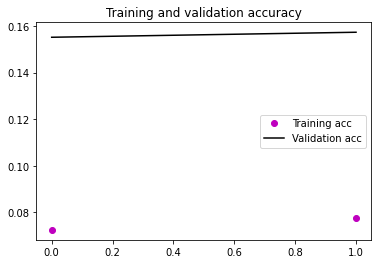

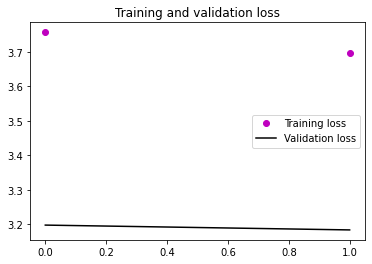

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'mo', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'mo', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Fine tuning last several layers.

In [41]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-42-4287107a2cee>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
89/89 [==============================] - 73s 728ms/step - loss: 3.7714 - acc: 0.0802 - val_loss: 3.2235 - val_acc: 0.1401
Epoch 2/2
81/89 [==========================>...] - ETA: 4s - loss: 3.7954 - acc: 0.0734

Process Keras_worker_ForkPoolWorker-25:
Process Keras_worker_ForkPoolWorker-27:
Process Keras_worker_ForkPoolWorker-28:
Process Keras_worker_ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._targ

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'mo', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'mo', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [ ]:
# os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
# model.save('/content/drive/My Drive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5')

In [ ]:
# from google.colab import files
# files.download('./content/drive/My Drive/cut_panoramic/รอบแรก_Flimpano_Female_250.h5')